# Graph Q-Learning

This project is extended from:

https://www.geeksforgeeks.org/ml-reinforcement-learning-algorithm-python-implementation-using-q-learning/

Here, we illustrate graph Q-Learning via a graph network

There are several issues with the original work, which we will address and fix in this project.

Feel free to explore and edit the code accordingly.

# Step 1: Importing the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# Step 2: Defining and visualising the graph

We fixed the seed of the layout for better illustration. Else, it may be very difficult to compare the results later

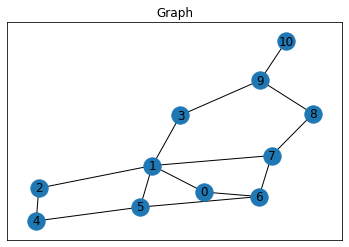

In [2]:
edges = [(0, 1), (1, 5), (5, 6), (5, 4), (1, 2), 
         (1, 3), (9, 10), (2, 4), (0, 6), (6, 7),
         (8, 9), (7, 8), (1, 7), (3, 9)]
  
goal = 10
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, seed=1)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)

plt.title('Graph')
plt.show()

# Step 3: Defining the reward the system for the bot

We noticed that the reward for path 9->10 is 100, while the reward for path 10->9 is 0.
This is because there is no meaning travelling from 10->9, as we had already reached the end goal (10).

In [3]:
MATRIX_SIZE = 11
M = np.matrix(np.ones(shape =(MATRIX_SIZE, MATRIX_SIZE)))
M *= -1

for point in edges:
    #print(point)
    if point[1] == goal:
        M[point] = 100
    else:
        M[point] = 0
  
    if point[0] == goal:
        M[point[::-1]] = 100
    else:
        M[point[::-1]]= 0
        # reverse of point
        
M[goal, goal]= 100

print(M.shape)
# add goal point round trip
import pandas as pd

print(pd.DataFrame(M.astype(int), columns=list(range(11))))

(11, 11)
    0   1   2   3   4   5   6   7   8   9    10
0   -1   0  -1  -1  -1  -1   0  -1  -1  -1   -1
1    0  -1   0   0  -1   0  -1   0  -1  -1   -1
2   -1   0  -1  -1   0  -1  -1  -1  -1  -1   -1
3   -1   0  -1  -1  -1  -1  -1  -1  -1   0   -1
4   -1  -1   0  -1  -1   0  -1  -1  -1  -1   -1
5   -1   0  -1  -1   0  -1   0  -1  -1  -1   -1
6    0  -1  -1  -1  -1   0  -1   0  -1  -1   -1
7   -1   0  -1  -1  -1  -1   0  -1   0  -1   -1
8   -1  -1  -1  -1  -1  -1  -1   0  -1   0   -1
9   -1  -1  -1   0  -1  -1  -1  -1   0  -1  100
10  -1  -1  -1  -1  -1  -1  -1  -1  -1   0  100


# Step 4: Defining some utility functions to be used in the training

We shift amended the code such that the functions are independent of the position where variables declared.
Originally, some variables must be declared before the functions, which is a poor software engineering practice.

Here, we implemented 3 functions:
- available_actions: At a given state (node), we check what are the available route
- sample_next_action: We choose the available route at random
- update: We update the Q matrix and the score
- find_optimal_path: Find the best path from start to goal based on Q matrix

In [4]:
# Determines the available actions for a given state
def available_actions(state):
    current_state_row = M[state, ]
    available_action = np.where(current_state_row >= 0)[1]
    return available_action
  
# Chooses one of the available actions at random
def sample_next_action(available_actions_range):
    next_action = int(np.random.choice(available_action, 1))
    return next_action
  
# Updates the Q-Matrix according to the path chosen
def update(Q, current_state, action, gamma):
    
    # We find the route with the highest Q
    max_index = np.where(Q[action, ] == np.max(Q[action, ]))[1]
    
    # If there is more than 1 route with the highest Q
    # Choose a random route among them
    if max_index.shape[0] > 1:
        max_index = int(np.random.choice(max_index, size = 1))
    else:
        max_index = int(max_index)
    
    # Update the Q Matrix based
    max_value = Q[action, max_index]
    Q[current_state, action] = M[current_state, action] + gamma * max_value
    
    if (np.max(Q) > 0):
        return (Q, np.sum(Q / np.max(Q)*100))
    else:
        return (Q, 0)
    
def find_optimal_path(Q, current_state, goal):
    current_state = 0
    steps = [current_state]

    while current_state != goal:

        next_step_index = np.where(Q[current_state, ] == np.max(Q[current_state, ]))[1]
        if next_step_index.shape[0] > 1:
            next_step_index = int(np.random.choice(next_step_index, size = 1))
        else:
            next_step_index = int(next_step_index)
        steps.append(next_step_index)
        current_state = next_step_index
    
    print("\nMost efficient path:", steps)

# Step 5: Training and evaluating the bot using the Q-Matrix

Trained Q matrix:
    0   1   2   3   4   5   6   7   8   9    10
0    0  42   0   0   0   0  32   0   0   0    0
1   32   0  32  56   0  32   0  42   0   0    0
2    0  42   0   0  24   0   0   0   0   0    0
3    0  42   0   0   0   0   0   0   0  75    0
4    0   0  32   0   0  32   0   0   0   0    0
5    0  42   0   0  24   0  32   0   0   0    0
6   32   0   0   0   0  32   0  42   0   0    0
7    0  42   0   0   0   0  32   0  56   0    0
8    0   0   0   0   0   0   0  42   0  75    0
9    0   0   0  56   0   0   0   0  56   0  100
10   0   0   0   0   0   0   0   0   0  75  100

Most efficient path: [0, 1, 3, 9, 10]


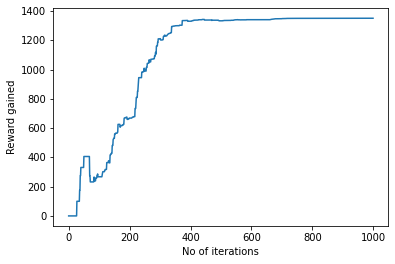

In [5]:
# Initalize
Q = np.matrix(np.zeros([MATRIX_SIZE, MATRIX_SIZE]))

# learning parameter
gamma = 0.75
initial_state = 1

# Train
scores = []
for i in range(1000):
    current_state = np.random.randint(0, int(Q.shape[0]))
    available_action = available_actions(current_state)
    action = sample_next_action(available_action)
    (Q, score) = update(Q, current_state, action, gamma)
    scores.append(score)
    
# View the trained Q matrix
print('Trained Q matrix:')
output = np.round(Q / np.max(Q)*100, 0)
print(pd.DataFrame(output.astype(int), columns=list(range(11))))

# Find optimal path
find_optimal_path(Q, 0, 10)

# Plot reward gained over iteration
plt.plot(scores)
plt.xlabel('No of iterations')
plt.ylabel('Reward gained')
plt.show()

# Step 6: Defining and visualizing the new graph with the environmental clues
Same problem, but here we add more details for better understanding and visualization

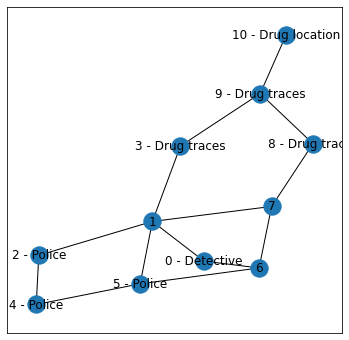

In [6]:
# Defining the locations of the police and the drug traces
police = [2, 4, 5]
drug_traces = [3, 8, 9]

G = nx.Graph()
G.add_edges_from(edges)
mapping = {0:'0 - Detective', 
           1:'1', 
           2:'2 - Police', 
           3:'3 - Drug traces',
           4:'4 - Police', 
           5:'5 - Police', 
           6:'6', 
           7:'7', 
           8:'8 - Drug traces',
           9:'9 - Drug traces', 
           10:'10 - Drug location'}

plt.figure(figsize=(6,6))
H = nx.relabel_nodes(G, mapping)
pos = nx.spring_layout(H, seed=1)
nx.draw_networkx_nodes(H, pos) # node_size =[200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
nx.draw_networkx_edges(H, pos)
nx.draw_networkx_labels(H, pos)
plt.show() 

# Step 7: Defining some utility functions for the training process
Here, we make some changes by adding environmental data (police and drug trace)

In [7]:
# Exploring the environment
def collect_environmental_data(action):
    found = []
    if action in police:
        found.append('p')
    if action in drug_traces:
        found.append('d')
    return (found)
  
def update(Q, env_police, env_drugs, current_state, action, gamma):
    max_index = np.where(Q[action, ] == np.max(Q[action, ]))[1]
    if max_index.shape[0] > 1:
        max_index = int(np.random.choice(max_index, size = 1))
    else:
        max_index = int(max_index)
    
    max_value = Q[action, max_index]
    Q[current_state, action] = M[current_state, action] + gamma * max_value
    environment = collect_environmental_data(action)
  
    if 'p' in environment:
        env_police[current_state, action] += 1
    if 'd' in environment:
        env_drugs[current_state, action] += 1

    if (np.max(Q) > 0):
        return (Q, env_police, env_drugs, np.sum(Q / np.max(Q)*100))
    else:
        return (Q, env_police, env_drugs, 0)

# Step 8: Visualising the Environmental matrices

Trained Q matrix:
    0   1   2   3   4   5   6   7   8   9    10
0    0  42   0   0   0   0  31   0   0   0    0
1   31   0  31  56   0  31   0  42   0   0    0
2    0  42   0   0  23   0   0   0   0   0    0
3    0  42   0   0   0   0   0   0   0  75    0
4    0   0  31   0   0  31   0   0   0   0    0
5    0  42   0   0  23   0  31   0   0   0    0
6   31   0   0   0   0  31   0  42   0   0    0
7    0  42   0   0   0   0  31   0  56   0    0
8    0   0   0   0   0   0   0  42   0  75    0
9    0   0   0  56   0   0   0   0  56   0  100
10   0   0   0   0   0   0   0   0   0  75  100

Police Found:
    0   1   2   3   4   5   6   7   8   9   10
0    0   0   0   0   0   0   0   0   0   0   0
1    0   0  15   0   0  19   0   0   0   0   0
2    0   0   0   0  43   0   0   0   0   0   0
3    0   0   0   0   0   0   0   0   0   0   0
4    0   0  57   0   0  34   0   0   0   0   0
5    0   0   0   0  41   0   0   0   0   0   0
6    0   0   0   0   0  30   0   0   0   0   0
7    0   0   0 

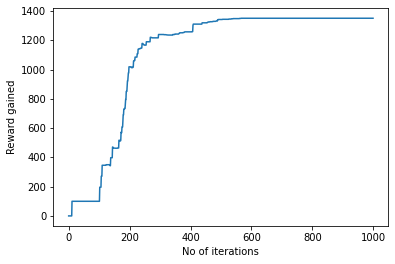

In [8]:
# Initalize
Q = np.matrix(np.zeros([MATRIX_SIZE, MATRIX_SIZE]))
env_police = np.matrix(np.zeros([MATRIX_SIZE, MATRIX_SIZE]))
env_drugs = np.matrix(np.zeros([MATRIX_SIZE, MATRIX_SIZE]))

# learning parameter
gamma = 0.75
initial_state = 1

# Train
scores = []
for i in range(1000):
    current_state = np.random.randint(0, int(Q.shape[0]))
    available_action = available_actions(current_state)
    action = sample_next_action(available_action)
    
    (Q, 
     env_police, env_drugs, 
     score) = update(Q, 
                     env_police,  env_drugs, 
                     current_state, 
                     action, 
                     gamma
                    )
    scores.append(score)

# View the trained Q matrix
print("Trained Q matrix:")
output = np.round(Q / np.max(Q)*100, 1)
print(pd.DataFrame(output.astype(int), columns=list(range(11))))

# print environmental matrices
print('\nPolice Found:')
print(pd.DataFrame(env_police.astype(int), columns=list(range(11))))
print('\nDrug traces Found:')
print(pd.DataFrame(env_drugs.astype(int), columns=list(range(11))))

# Find optimal path
find_optimal_path(Q, 0, 10)

# Plot reward gained over iteration
plt.plot(scores)
plt.xlabel('No of iterations')
plt.ylabel('Reward gained')
plt.show()